# Homograhpy 를 사용한 Image Stitching (HW #1)
      
아래 모습처럼 5장의 사진을 촬영 하고 center 사진을 기준으로 상하좌우  
4장의 사진의 homography를 구하여 이미지를 stitching 합니다.

  | --------------- Top -----------------|  
  | --- Left - Center - Right --- |   
  | ------------ Bottom --------------|  

### 1. 필요한 라이브러리를 import 합니다.

In [430]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [431]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

### 2. 직접 촬영한 사진을 가져옵니다.
* 스마트폰의 기본 설정으로 촬영할 경우 해상도가 너무 높아, 연산 시간이 길어지게 됩니다.따라서 **resize** 를 권유합니다.

/content/drive/My Drive/HW1
 3DDP24_HW1.pdf		    center.jpg	  result2.jpg	    upper.jpg
 3DDP_HW1_Stitching.ipynb   left.jpg	  result3_N_8.jpg  '나름 성공적이였던 결과물'
 below.jpg		    result1.jpg   right.jpg
/content/drive/MyDrive/HW1
원본 해상도: (1440, 1080, 3)
Resize 해상도:  (360, 270, 3)


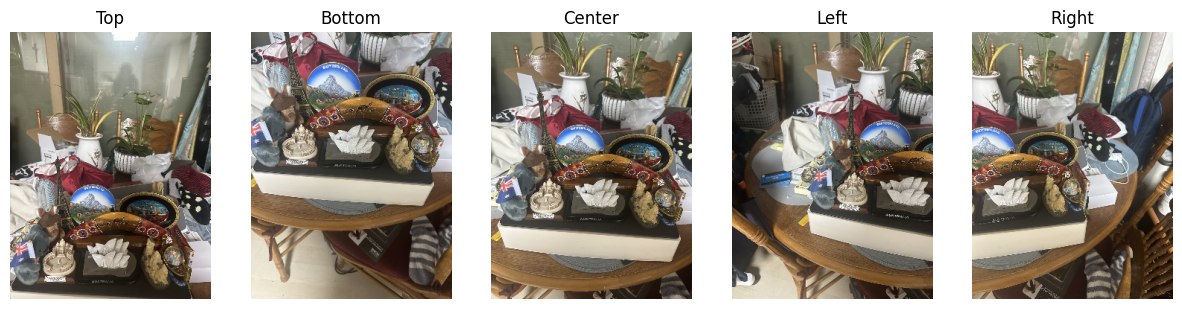

In [432]:
def display_images(images, titles):
    num_images = len(images)
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    for i in range(num_images):
        images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)
        axes[i].imshow(images[i], cmap='gray')
        axes[i].set_title(titles[i])
        axes[i].axis('off')

    plt.show()

!pwd
!ls
## 사진 가져오기
# 사진 경로 설정 주의! (본인의 디렉토리에 맞추길 바랍니다.)
# stiching 원본 이미지들의 해상도(사진 크기)는 모두 갖다고 가정합니다.
# %cd /content/drive/MyDrive/'Colab Notebooks'/3DDP/stitch/
%cd /content/drive/MyDrive/HW1/

center = cv2.imread('center.jpg')
top = cv2.imread('upper.jpg')
bottom = cv2.imread( 'below.jpg')
left = cv2.imread('left.jpg')
right = cv2.imread( 'right.jpg')
print('원본 해상도:', center.shape)

## Resize
center = cv2.resize(center, dsize=(0,0), fx=0.25, fy=0.25, interpolation=cv2.INTER_LINEAR)
top = cv2.resize(top, dsize=(0,0), fx=0.25, fy=0.25, interpolation=cv2.INTER_LINEAR)
bottom = cv2.resize(bottom, dsize=(0,0), fx=0.25, fy=0.25, interpolation=cv2.INTER_LINEAR)
left = cv2.resize(left, dsize=(0,0), fx=0.25, fy=0.25, interpolation=cv2.INTER_LINEAR)
right = cv2.resize(right, dsize=(0,0), fx=0.25, fy=0.25, interpolation=cv2.INTER_LINEAR)
print('Resize 해상도: ', top.shape)

images = [top, bottom, center, left, right]
titles = ['Top', 'Bottom', 'Center', 'Left', 'Right']

display_images(images, titles)

## 3. 이미지에 offset을 더합니다.
* 이는 warping 을 했을 때 연산을 편리하게 하기 위한 과정입니다. 만약, warping 한 이미지가 offset을 초과 한다면 기본 offset=200 을 조정하기 바랍니다.


In [433]:
# Offset 예시입니다. 본인의 영상으로 할 경우 사이즈가 안맞을 수 있으며 조절 가능합니다.

def offset_maker(img):
    h, w, c = img.shape
    margin = 200 # warping 했을 때 offset을 초과 한다면 이 값을 키워줍니다.
    result = np.zeros((h + margin*2, w + margin*2, 3), dtype=np.uint8) # uint8 설정하지 않으면 안된다.
    result[margin: margin+h, margin: margin+w] = img

    return result

print('Before Offset')
print(center.shape)

center = offset_maker(center)
top = offset_maker(top)
bottom = offset_maker(bottom)
left = offset_maker(left)
right = offset_maker(right)

print('After Offset')
print(center.shape)
# print(center[600][650])


Before Offset
(360, 270, 3)
After Offset
(760, 670, 3)


## 4. SIFT를 사용하여 특징을 추출합니다.

In [434]:
#SIFT
sift = cv2.SIFT_create()

#색상 Gray로 변경
gray_center = cv2.cvtColor(center, cv2.COLOR_BGR2GRAY)
gray_top = cv2.cvtColor(top, cv2.COLOR_BGR2GRAY)
gray_bottom = cv2.cvtColor(bottom, cv2.COLOR_BGR2GRAY)
gray_left = cv2.cvtColor(left, cv2.COLOR_BGR2GRAY)
gray_right = cv2.cvtColor(right, cv2.COLOR_BGR2GRAY)

#key point 와 descriptor 추출
#key point는 위치, descriptor는 특징
kp_center, des_center = sift.detectAndCompute(gray_center, None)
kp_top, des_top = sift.detectAndCompute(gray_top, None)
kp_bottom, des_bottom = sift.detectAndCompute(gray_bottom, None)
kp_left, des_left = sift.detectAndCompute(gray_left, None)
kp_right, des_right = sift.detectAndCompute(gray_right, None)

#center와 상하좌우에 있는 robust feature만 matching시켜서 추출
bf = cv2.BFMatcher()
matches_center_top = bf.knnMatch(des_center, des_top, k=2)
matches_center_bottom = bf.knnMatch(des_center, des_bottom, k=2)
matches_center_left = bf.knnMatch(des_center, des_left, k=2)
matches_center_right = bf.knnMatch(des_center, des_right, k=2)

good_matches_center_top = []
for m, n in matches_center_top:
    if m.distance < 0.75 * n.distance:
        good_matches_center_top.append(m)

good_matches_center_bottom = []
for m, n in matches_center_bottom:
    if m.distance < 0.75 * n.distance:
        good_matches_center_bottom.append(m)

good_matches_center_left = []
for m, n in matches_center_left:
    if m.distance < 0.75 * n.distance:
        good_matches_center_left.append(m)

good_matches_center_right = []
for m, n in matches_center_right:
    if m.distance < 0.75 * n.distance:
        good_matches_center_right.append(m)

#center를 top에 맞춘다.
src_pts_top = np.float32([kp_center[m.queryIdx].pt for m in good_matches_center_top]).reshape(-1, 1, 2) #center
dst_pts_top = np.float32([kp_top[m.trainIdx].pt for m in good_matches_center_top]).reshape(-1, 1, 2) #top

src_pts_bottom = np.float32([kp_center[m.queryIdx].pt for m in good_matches_center_bottom]).reshape(-1, 1, 2)
dst_pts_bottom = np.float32([kp_bottom[m.trainIdx].pt for m in good_matches_center_bottom]).reshape(-1, 1, 2)

src_pts_left = np.float32([kp_center[m.queryIdx].pt for m in good_matches_center_left]).reshape(-1, 1, 2)
dst_pts_left = np.float32([kp_left[m.trainIdx].pt for m in good_matches_center_left]).reshape(-1, 1, 2)

src_pts_right = np.float32([kp_center[m.queryIdx].pt for m in good_matches_center_right]).reshape(-1, 1, 2)
dst_pts_right = np.float32([kp_right[m.trainIdx].pt for m in good_matches_center_right]).reshape(-1, 1, 2)

# print(src_pts_right)
# print(src_pts_right.shape)
# for x in range(len(src_pts_right)):
#   print(src_pts_right[x], dst_pts_right[x])
#src는 center값, dst는 상하좌우 값

## 5. Homography & Warping

만일 Homography using SVD를 구현할 경우 이 곳에 함수를 작성하세요

In [435]:
# 만일 Homography using SVD를 구현할 경우 이 곳에 함수를 작성하세요
# deg myHomographySVD(...)
import random
import math
from mpmath import mp
def myHomographySVD(src_pts, dst_pts):
  #step 1 - 전체에서 N개의 pair 추출
  N = 8 #비교 pair 수
  src_temp = np.float32([[0]*2]*N) #a -> aH - b = 0에 가깝게
  dst_temp = np.float32([[0]*2]*N) #b
  for i in range(N):
    x = int(random.random()*len(src_pts))
    # print(x)
    src_temp[i] = src_pts[x]
    dst_temp[i] = dst_pts[x]

  #cv2.findHomography 이용
  # rtval, mask = cv2.findHomography(src_temp, dst_temp, method= None, ransacReprojThreshold=None, mask=None, maxIters=1, confidence=None)
  # print(rtval, mask)

  #step 2 - matrix 구하기
  A_Matrix = np.float32([])
  for n in range(N):
    xa, ya, xb, yb = src_temp[n][0],src_temp[n][1], dst_temp[n][0], dst_temp[n][1]
    # print(xa,ya,xb,yb)
    row1 = np.float32([xb, yb, 1,0,0,0,-xa*xb,-xa*yb, -xa])
    row2 = np.float32([0,0,0,xb,yb,1,-xb*ya,-ya*yb,-ya])
    # AB_Matrix.add(row1)
    A_Matrix = np.append(A_Matrix,[row1])
    A_Matrix = np.append(A_Matrix,[row2]).reshape(2*(n+1),9)
  # print(A_Matrix, A_Matrix.shape)

  #step 3 - SVD 구현
  [U, S, Vt] = np.linalg.svd(A_Matrix)
  Homography = (Vt[9-1].reshape(3,3))
  # AtA = np.array(np.transpose(A_Matrix)) @ np.array(A_Matrix)
  # eigenvalues,eigenVectors = np.linalg.eig(AtA)
  # Sigma = np.float32([0]*(2*N*9)).reshape(2*N,9)
  # for i in range(2*N):
  #   Sigma[i][i] = math.sqrt(eigenvalues[i])
  # print(Sigma)
  return Homography


H = myHomographySVD(src_pts_top, dst_pts_top)
print(H)


[[-2.5833191e-03 -8.0373959e-04  5.7805789e-01]
 [-9.7909512e-04 -2.6689761e-03  8.1598628e-01]
 [-2.8376180e-06 -2.7879178e-06  2.8598981e-04]]


만일 RANSAC을 구현할 경우 이 곳에 함수를 작성하세요

In [436]:
# 만일 RANSAC을 구현할 경우 이 곳에 함수를 작성하세요
# def my_homography_ransac(...)
def my_homography_ransac(src_pts,dst_pts):
  maxIter = 3000 #비교 pair 수
  performance = -1
  homography = -1
  for _ in range(maxIter):
    H_temp = myHomographySVD(src_pts,dst_pts)
    inlier = 0
    for i, src_pt in enumerate(src_pts):
      dst_pt = dst_pts[i]
      transformed = np.append(dst_pt,1)

      calc = np.array(H_temp) @ np.array(np.transpose(transformed))
      calc[0] = calc[0]/calc[2]
      calc[1] = calc[1]/calc[2]
      calc[2] = calc[2]/calc[2]

      d= math.sqrt((calc[0]-src_pt[0][0])**2+(calc[1]-src_pt[0][1])**2)
      if(d<=30):
        inlier+=1
        # print(src_pt)
        # print(calc)
    if performance < (inlier/len(src_pts)):
      performance = (inlier/len(src_pts))
      homography = H_temp
      print(performance)
    if performance >=0.98:
      break
  # cv2.findHomography(src_temp,dst_temp, method = 'RANSAC',params= N)
  # rtval, mask = cv2.findHomography(src_temp, dst_temp, method= None, ransacReprojThreshold=None, mask=None, maxIters=None, confidence=None)
  print("homography found!!!")
  return homography


#예시
homography_right = my_homography_ransac(src_pts_right,dst_pts_right)
print(homography_right)

0.35772357723577236
0.7317073170731707
0.926829268292683
0.9349593495934959
0.9512195121951219
homography found!!!
[[-7.1121845e-04  2.1186256e-04 -8.7855744e-01]
 [ 1.4925926e-03 -2.5710291e-03 -4.7760987e-01]
 [ 4.3273208e-06  3.0576692e-07 -4.0306239e-03]]


In [437]:
# 영상간 Homography를 구하고 Warping 함수를 작성합니다.
# cv2.findHomography(homography 추정, 기본 점수) 및 cv2.warpPerspective를 사용하여 구현 할 수 있습니다.
# 다만, cv2.findHomography 대신 위의 함수(my_homography_ransac)를 이용하여 호모그래피를 사용할 경우 추가 점수가 있습니다.

def Warping(src_pts,dst_pts,pics):
  panorama = center
  for i in range(4):
    Homograppy = my_homography_ransac(src_pts[i],dst_pts[i])
    warped = cv2.warpPerspective(pics[i], Homograppy, (0,0))
    # cv2_imshow(warped)
    for row in range(warped.shape[0]):
      for col in range(warped.shape[1]):
        if (sum(warped[row][col])!= 0):
          panorama[row][col] = warped[row][col]
  return panorama



## 6. Stitching

In [438]:
# warping 함수를 이용하여 직접 이미지를 이어 붙이시길 바라며, 결과를 출력하고 저장하세요
src_pts = [src_pts_right,src_pts_left,src_pts_top,src_pts_bottom]
dst_pts = [dst_pts_right,dst_pts_left,dst_pts_top,dst_pts_bottom]
pics = [right, left, top, bottom]

panorama = Warping(src_pts,dst_pts,pics)

0.45528455284552843
0.8455284552845529
0.926829268292683
0.943089430894309
0.9512195121951219
homography found!!!
0.06542056074766354
0.7757009345794392
0.822429906542056
0.8598130841121495
0.8691588785046729
homography found!!!
0.9238095238095239
0.9285714285714286
0.9333333333333333
homography found!!!
0.967741935483871
homography found!!!


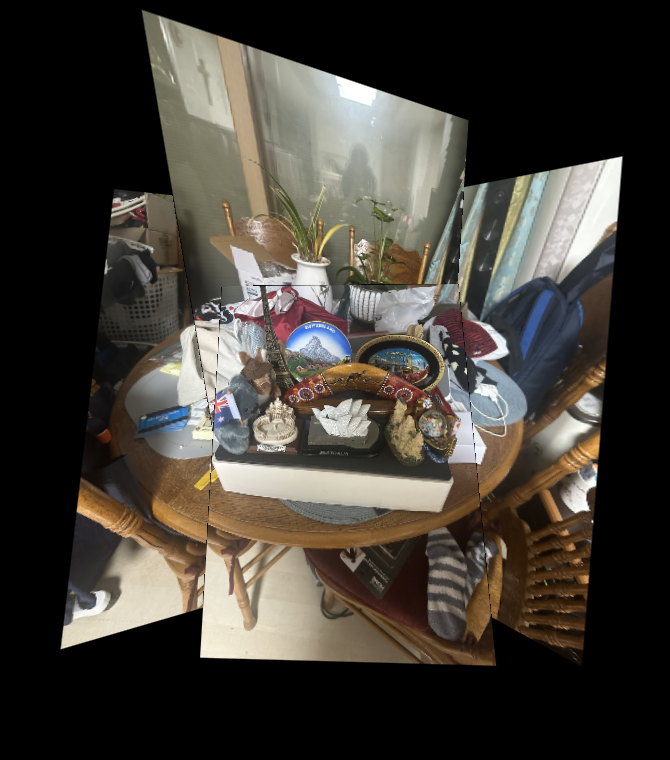

True

In [439]:
cv2_imshow(panorama)

# 저장하기 cv2.imwrite(..) 로 저장하고 제출
cv2.imwrite("result3_N_8_t2.jpg",panorama)